<a href="https://colab.research.google.com/github/ZYLIM0702/AI_Fashion_Cloth_Changer/blob/main/WearifAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Setup environment for AI model training
!wget -q https://raw.githubusercontent.com/ZYLIM0702/AI_Fashion_Cloth_Changer/main/train_dreambooth.py
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py
%pip install -qq git+https://github.com/ShivamShrirao/diffusers
%pip install -q -U --pre triton
%pip install -q accelerate transformers ftfy bitsandbytes==0.35.0 gradio natsort safetensors xformers
!pip install open_clip_torch omegaconf einops pytorch_lightning share

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.7/302.7 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 45.6 MB/s eta 0:00:00
     ━━

## Dataset Preparation

Our clothing dataset is collected from various platforms (for demonstrate purpose), and we analyze, clean, and categorize them based on their types.

Primarily, our clothes are grouped into two types: Tops and Bottoms. Due to resource limitations, we have selected 24 items from the raw dataset.

  - Under the 'Top' category, there are various types of clothing, including hoodies, jackets, shirts, blazers, suits, cropped, and more.

  - On the other hand, the 'Bottom' category includes jeans, track bottoms, slacks, and more."

In [ ]:
# @title Create directory for saving model and import (Prepared/Cleaned dataset)
import os
import zipfile
MODEL_NAME = "dreamlike-art/dreamlike-photoreal-2.0"

OUTPUT_DIR = "model"

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")


In [ ]:
# @title Remove non-image files in dataset
import os
from PIL import Image

%cd /content/
def delete_ds_store_files(folder_path):
    for content, dirs, files in os.walk(folder_path):
        for file in files:
            if file == ".DS_Store":
                file_path = os.path.join(content, file)
                os.remove(file_path)
                print(f"Deleted: {file_path}")

# Specify the folder path where you want to delete .DS_Store files
folder_path = "dataset"

# Call the function to delete .DS_Store files
delete_ds_store_files(folder_path)


print("Processing complete.")

/content
Processing complete.


In [ ]:
# @title Clear cache if the following failed
import torch
torch.cuda.empty_cache()

## Training AI model

DreamBooth is a deep learning generation model used to personalize existing text-to-image models by fine-tuning. Our model is trained by Dreambooth, a training technique that can synthesized images with specified viewpoints for a subject.

We used clothes' product images with specified instance prompts and class prompts to train this model. Those labeling and tagging is done under concepts_list.json.

***Training Preferences***
- Pretrained model - dreamlike-art/dreamlike-photoreal-2.0 (base model version Stable diffusion v1.5)
- Pretrained VAE - stabilityai/sd-vae-ft-mse
- Train with 1.0 prior loss weight
- Specified seed (random number) //in order to ease fine tuning model
- Train with image resolution 512x512
- Batch size - 1
- Training include Text Encoder
- Use 8 bit adam (prevent exceeding GPU memory)
- Learning Rate - 3e-6 == 0.000003
- Learning scheduler - constant
- Learning warm up steps - 0
- Number of images for each class - 100
- Sample batch size - 4
- Max training steps - 2880 (number of items * 120 steps)

The purpose of using this specific pretrained model is because it includes inpainting model which is required by our solution and it is pretrained with those realistic images.

In [ ]:
# @title Start training our AI model
!python3 /content/train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse" \
  --output_dir=$OUTPUT_DIR \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --seed=1337 \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --learning_rate=3e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=100 \
  --sample_batch_size=4 \
  --max_train_steps=2880 \
  --concepts_list="/content/dataset/concepts_list.json"


WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.1.0+cu121 with CUDA 1201 (you have 2.1.0+cu118)
    Python  3.10.13 (you have 3.10.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
2023-12-02 09:51:03.044133: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-02 09:51:03.044194: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-02 09:51:03.044225: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin c

  0%|          | 0/50 [00:00<?, ?it/s]

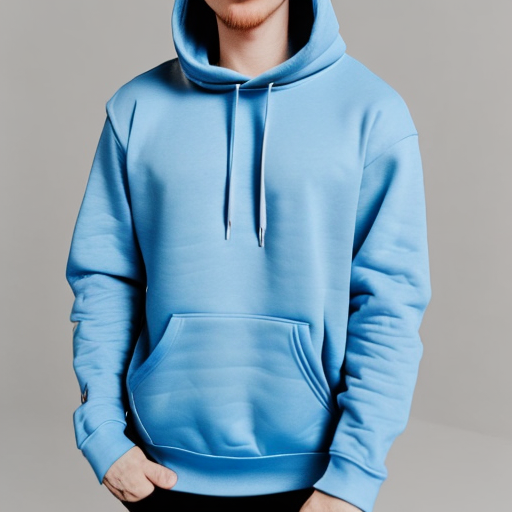

In [ ]:
# @title Test fine-tuned AI model
from diffusers import DiffusionPipeline
import torch

model_id = "model/2880"
pipe = DiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")

prompt = "A photo of a man wears cottonXcasualXhoodieXblue hoodie"
image = pipe(prompt, num_inference_steps=50, guidance_scale=9, width=512,height=512).images[0]

image.save("person-cottonXcasualXhoodieXblue-hoodie.png")
image

In [ ]:
# @title Upload AI model to Google Drive for future usage
#rename the model folder name
import os
from google.colab import drive
drive.mount('/content/drive')

old_name = r"/content/model/2880"
new_name = r"/content/model/AIClothesChanger"
os.rename(old_name, new_name)

!cp -r /content/model/AIClothesChanger /content/drive/MyDrive/AIClothesChanger

Mounted at /content/drive


In [ ]:
# @title Copy AI model from Google Drive
from google.colab import drive
drive.mount('/content/drive')
!cp -r /content/drive/MyDrive/AIClothesChanger /content

Mounted at /content/drive


In [ ]:
# @title Inference | DreamLike Photoreal v2 + Custom Clothes Model -> Inpainting + ControlNet (OpenPose)
!pip install diffusers xformers transformers scipy ftfy accelerate controlnet_aux safetensors omegaconf

from diffusers import StableDiffusionInpaintPipeline, ControlNetModel, UniPCMultistepScheduler, StableDiffusionControlNetInpaintPipeline
from diffusers.utils import load_image
import numpy as np
import torch
import diffusers
from controlnet_aux import OpenposeDetector
from PIL import Image

device = torch.device('cuda')

controlnet = ControlNetModel.from_pretrained('lllyasviel/sd-controlnet-openpose', torch_dtype=torch.float16)


pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained("AIClothesChanger",controlnet = controlnet, torch_dtype=torch.float16).to('cuda')

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)


openpose = OpenposeDetector.from_pretrained('lllyasviel/ControlNet')
pipe.to('cuda')

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

body_pose_model.pth:   0%|          | 0.00/209M [00:00<?, ?B/s]

hand_pose_model.pth:   0%|          | 0.00/147M [00:00<?, ?B/s]

facenet.pth:   0%|          | 0.00/154M [00:00<?, ?B/s]

StableDiffusionControlNetInpaintPipeline {
  "_class_name": "StableDiffusionControlNetInpaintPipeline",
  "_diffusers_version": "0.24.0",
  "_name_or_path": "AIClothesChanger",
  "controlnet": [
    "diffusers",
    "ControlNetModel"
  ],
  "feature_extractor": [
    null,
    null
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": null,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "UniPCMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/20 [00:00<?, ?it/s]

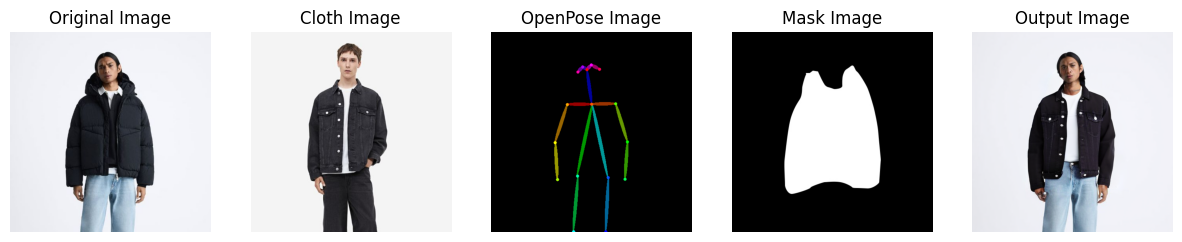

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Load the pose real image
pose_real_image = Image.open("/content/hooded_puffer_jacket 1.jpg").convert("RGB")

# Process the real pose image using the openpose function
pose_image = openpose(pose_real_image)
pose_image = pose_image.resize((pose_real_image.width,pose_real_image.height))

# Load the pose mask image
pose_mask = Image.open("/content/mask.jpg").convert("RGB")

# Load Original image
cloth_image = Image.open("/content/M-Black 2002.jpeg").convert("RGB")

new_image = pipe(
    "a man wearing casualXJeansXblackXrelaxXdenimXjacket jacket",
    num_inference_steps=20,
    image=pose_real_image,
    control_image=pose_image,
    mask_image=pose_mask,
    guidance_scale=9,
).images[0]

# Display images side by side
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

# Plotting the first image
axes[0].imshow(pose_real_image)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Plotting the second image
axes[1].imshow(cloth_image)
axes[1].set_title("Cloth Image")
axes[1].axis("off")

# Plotting the third image
axes[2].imshow(pose_image)
axes[2].set_title("OpenPose Image")
axes[2].axis("off")

# Plotting the fourth image
axes[3].imshow(pose_mask)
axes[3].set_title("Mask Image")
axes[3].axis("off")

# Plotting the fifth image
axes[4].imshow(new_image)
axes[4].set_title("Output Image")
axes[4].axis("off")


plt.show()


